In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 200)

# Analysis of Boston and Seattle Airbnb Open Data

### Questions to be answered by the Analysis:<br>
1. How much AirBNB homes are earning in certain time frames and areas? <br>
2. Is there anything about the properties that helps predict price? <br> 
3. Compare rates between Seattle and Boston. Are they different? <br>
<br>
Future works:<br>
Can you find negative and positive reviews based on text? <br>

### Reading csv files

We will first load and analyse data from Boston collected in 2020-02-13 <br>
The dataset was downloaded from the link http://insideairbnb.com/get-the-data.html


In [3]:
df_boston_listings = pd.read_csv('../data/boston/old/listings.csv')
df_boston_calendar = pd.read_csv('../data/boston/old/calendar.csv')

In [4]:
"""['property_type','room_type',accommodates	bathrooms	bedrooms	beds	bed_type,amenities,square_feet	price	weekly_price	monthly_price	security_deposit	cleaning_fee	guests_included	extra_people	minimum_nights	maximum_nights,number_of_reviews,first_review	last_review,review_scores_rating, review_scores_cleanliness,review_scores_location,cancellation_policy ]
"""

"['property_type','room_type',accommodates\tbathrooms\tbedrooms\tbeds\tbed_type,amenities,square_feet\tprice\tweekly_price\tmonthly_price\tsecurity_deposit\tcleaning_fee\tguests_included\textra_people\tminimum_nights\tmaximum_nights,number_of_reviews,first_review\tlast_review,review_scores_rating, review_scores_cleanliness,review_scores_location,cancellation_policy ]\n"

### Getting 7 random samples using the method df.sample() <br>
It is usually better to get random samples than the first (head) or last (tail) rows because  we get more data variability

In [5]:
df_boston_listings.sample(7)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
3014,377474,https://www.airbnb.com/rooms/377474,20160906204935,2016-09-07,Beautiful Victorian House,Beautiful Victorian house built in 1948. Clean...,"Beautiful Victorian house big and spacious, it...",Beautiful Victorian house built in 1948. Clean...,none,Good Vietnamese restaurant to the right of the...,Dorchester is a historical area of Boston. Tak...,From the airport: Taxi (cost around $35-40) UB...,"Dinning room, living room, kitchen, patio on t...","E-mail, phone, text, line: (PHONE NUMBER HIDDE...","Check-in is 2:00 pm, and checkout 11:00 am (th...",https://a1.muscache.com/im/pictures/4240739/d2...,https://a1.muscache.com/im/pictures/4240739/d2...,https://a1.muscache.com/im/pictures/4240739/d2...,https://a1.muscache.com/im/pictures/4240739/d2...,119019,https://www.airbnb.com/users/show/119019,Hermina,2010-05-05,"Boston, Massachusetts, United States","Originally from Armenia, I live in Boston for ...",within an hour,100%,100%,f,https://a2.muscache.com/im/users/119019/profil...,https://a2.muscache.com/im/users/119019/profil...,Dorchester,11,11,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Park St, Boston, MA 02122, United States",Dorchester,Dorchester,NaN,Boston,MA,02122,Boston,"Boston, MA",US,United States,42.298390,-71.059312,t,House,Entire home/apt,14,2.5,5.0,8.0,Real Bed,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",NaN,$395.00,NaN,NaN,$200.00,$140.00,8,$15.00,2,365,4 days ago,NaN,0,0,3,261,2016-09-06,19,2012-08-11,2015-09-13,85.0,8.0,9.0,9.0,9.0,7.0,8.0,f,NaN,NaN,f,strict,f,t,9,0.38
1096,2513870,https://www.airbnb.com/rooms/2513870,20160906204935,2016-09-07,South End. LUXURY 1 BEDROOM. 850sqf,"Best location, all attractions and stores. Cor...","Unique open stairs, kitchen, dining, living ro...","Best location, all attractions and stores. Cor...",none,My apartment is perfectly located on Columbus ...,ONE MONTH MINIMUM (June 2014) Possibility to r...,3 min walk to Amtrak station and Metro Green a...,Everything (except one closet where I store my...,"None, apart from setting the rental. The apart...","No kids, no pets, no smoking.",NaN,NaN,https://a1.muscache.com/im/pictures/33229406/f...,NaN,12867663,https://www.airbnb.com/users/show/12867663,Bruno,2014-03-06,"Cambridge, Massachusetts, United States",NaN,within an hour,100%,100%,f,https://a1.muscache.com/im/users/12867663/prof...,https://a1.muscache.com/im/users/12867663/prof...,South End,1,1,"['email', 'phone']",t,f,"Columbus Avenue, Boston, MA 02118, United States",South End,South End,NaN,Boston,MA,02118,Boston,"Boston, MA",US,United States,42.344826,-71.

In [6]:
df_boston_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

### Tranform monetary columns that is originaly a string to float. <br>
Eg. '$ 1,023.43' will be converted to 1023.43



In [7]:
monetary_cols = ['price','security_deposit','cleaning_fee','extra_people','weekly_price', 'monthly_price']
df_boston_listings[monetary_cols] = df_boston_listings[monetary_cols].astype(str).applymap(lambda x: re.sub('[$,]', '', x) if x is not None else x).astype(float)


In [8]:
rate_cols = ['host_response_rate','host_acceptance_rate']
df_boston_listings[rate_cols] = df_boston_listings[rate_cols].astype(str).applymap(lambda x: re.sub('[%]', '', x) if x is not None else x).astype(float)

In [9]:
df_boston_listings = df_boston_listings.drop(columns=['weekly_price','monthly_price'])

drop columns with less than 25% of the data filled

In [10]:
df_boston_listing = df_boston_listings.dropna(thresh=df_boston_listings.shape[0]*.25, axis=1)

drop weekly_price and monthly_price 

## 1. How much AirBNB homes are earning in certain areas?
To answer this question, we will analyse price by neighbourhood

### Plotting price distribution by neighbourhood

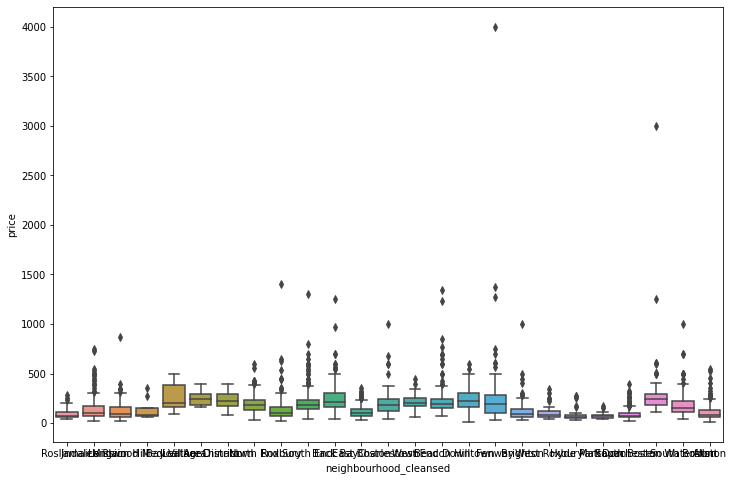

In [11]:
plt.figure(figsize=(12,8))
sns.boxplot(x='neighbourhood_cleansed', y='price', data=df_boston_listings);

<AxesSubplot:ylabel='neighbourhood_cleansed'>

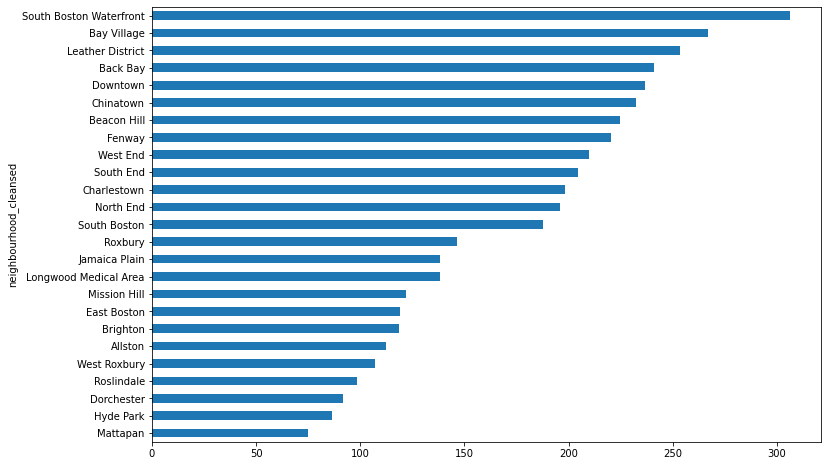

In [12]:
plt.figure(figsize=(12,8))
df_boston_listings.groupby('neighbourhood_cleansed')['price'].mean().sort_values().plot(kind='barh')

### Initial results - There are a lot of outliers
It seems like Leather District (\$1449) and Back Bay (\$579) have the highest average rates.
However, checking the box plot above we can see that there are some data points over the upper limit. Those outliers are probably influencing and shifting the price average. <br>
Let us make a deep analysis to figure out possible reasons for outliers. 


First we will analyse data from the 'Leather District' neighbourhood

In [13]:
df_boston_listings.loc[df_boston_listings['neighbourhood_cleansed']=='Leather District',['space','price']]

,space,price
550,2 bedrooms: - Master bedroom with king size be...,245.0
551,"Luxury condo, loft style, with 2 separate bedr...",390.0
552,"This Beautiful 1,500 sq ft, 2 bedroom condo ha...",159.0
553,"This Beautiful 1,500 sq ft, 2 bedroom condo ha...",295.0
554,Luxury apartment with the best location in Bos...,179.0


Wow. There is a input error on the second line! According to the 'space' column ('rental at \$4.999 per month'), the price \$3999 is probably per month, not per day. We will drop this line as it has wrong price.

In [14]:
df_boston_listings.drop(index=859, inplace=True)

Now, for each neighbourhood, we will remove data point that have price value above the upper limit using the formula: Q3 + 1.5*(Q3-Q1)

In [15]:
upper_1_5_IQR = df_boston_listings.groupby('neighbourhood_cleansed')['price'].agg(
        lambda x: np.quantile(x, 0.75) + (np.quantile(x, 0.75) - np.quantile(x, 0.25))*1.5
        )
upper_1_5_IQR = upper_1_5_IQR.to_dict()

df_boston_listings['upper_1_5_IQR'] = df_boston_listings['neighbourhood_cleansed'].map(upper_1_5_IQR)

df_boston_listings_wo_upper = df_boston_listings[df_boston_listings['price']<=df_boston_listings['upper_1_5_IQR']]

Now that we have a dataset without the upper limit outliers, let us plot the price average by neighbourhood again

<AxesSubplot:ylabel='neighbourhood_cleansed'>

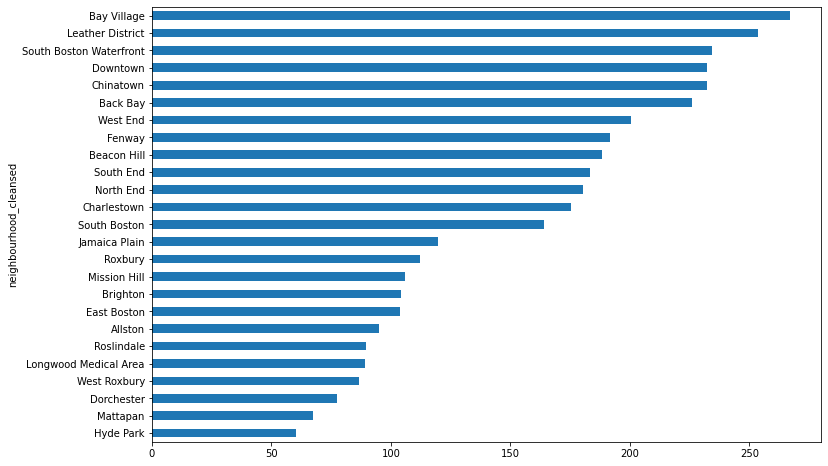

In [16]:
plt.figure(figsize=(12,8))
df_boston_listings_wo_upper.groupby('neighbourhood_cleansed')['price'].mean().sort_values().plot(kind='barh')

In [17]:
print('Total rows on the Original data = ', df_boston_listings.shape[0])
print('Total rows after removing wrong input and upper limit = ', df_boston_listings_wo_upper.shape[0])
print('Total rows rate after data cleaning', np.round(df_boston_listings_wo_upper.shape[0]/df_boston_listings.shape[0]*100,2))

Total rows on the Original data =  3584
Total rows after removing wrong input and upper limit =  3382
Total rows rate after data cleaning 94.36


In [18]:
print(np.round(df_boston_listings_wo_upper.groupby('neighbourhood_cleansed')['price'].mean().quantile(.16),2))
print(np.round(df_boston_listings_wo_upper.groupby('neighbourhood_cleansed')['price'].mean().quantile(.84),2))


88.77
232.37


### Results after removing outliers

After removing the incorrect input from Leather District (outlier), this neighbourhood is no longer TOP 1. <br><br>
After removing the upper limit from the dataset, Back Bay is no longer TOP 2. The price average dropped from \$579 to \$204 <br>
The upper limit outliers represent only 7.8% of all data (19/243) collected for Back Bay, so it is reasonable to consider \$204 as the price average for Back Bay based on 92.2% of the data. <br>

After removing the wrong input and the upper limit outliers, we have still keept 92% of the original data, the overall average price has dropped from \$198 to \$139. 
The plot above is now a more realistic view of the average price by neighbourhood. <br>




## 2. Is there anything about the properties that helps predict price?

To answer this question, we can first plot the correlation matrix for the numerical columns vs price, and then model a linear regression and analyse the coeficients



In [19]:
df_boston_listings = df_boston_listings_wo_upper

<AxesSubplot:>

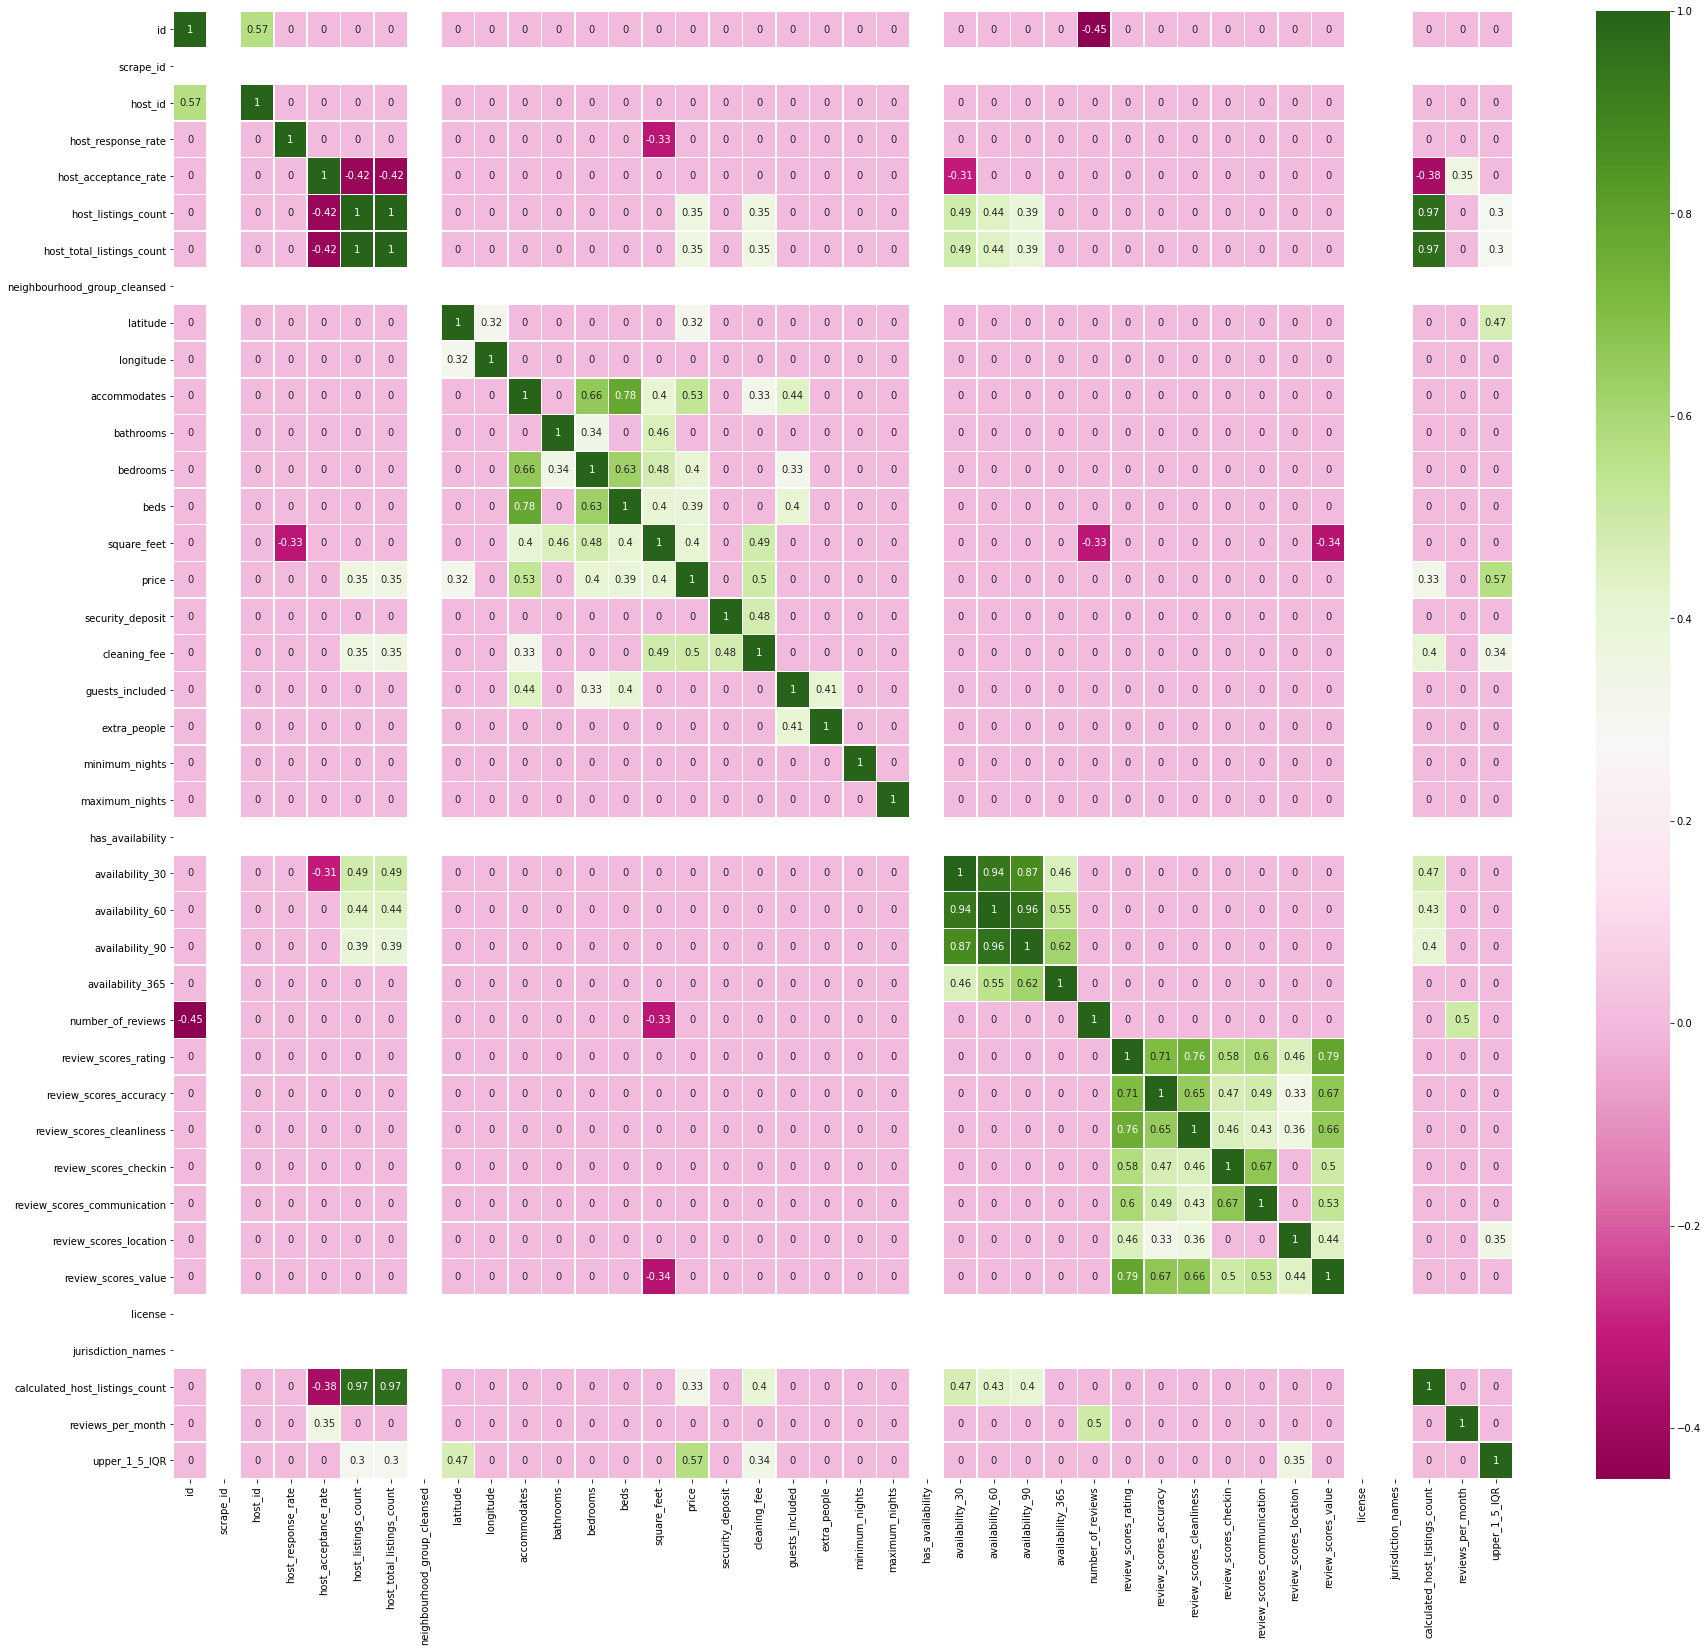

In [20]:
#sns.heatmap(df_boston_listings.corr())

corr = df_boston_listings.corr().round(2)
corr = corr.applymap(lambda x:  0 if x<0.3 and x>-0.3 else x)

plt.rcParams['figure.figsize'] = (30,27)
sns.heatmap(corr.round(2), annot=True,linewidths=.5, cmap="PiYG")

The feature 'square_feet' has a 0.45 correlation with 'price', which is considered as low-medium strength.<br>
From the correlation matrix above, we can also see that 'square_feet' is highly correlated with (accommodates, bathrooms, bedrooms, beds and guests_included)

In [32]:
correlated_columns = df_boston_listings.select_dtypes(np.number).columns[corr.price>0]


### categorical independent variables
There are 56 categorical columns on the original dataset. <br>
First we will eliminame categoricals features that are not significant based on ANOVA test

In [21]:
df_boston_listings = df_boston_listings.drop(columns=['neighbourhood','zipcode','upper_1_5_IQR'])

In [33]:

continuous = correlated_columns #df_boston_listings.select_dtypes(include=np.number).columns
categoricals = df_boston_listings.select_dtypes(exclude=np.number).columns

print('Total categorical columns = ', len(categoricals))

Total categorical columns =  54


In [34]:
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import OrdinalEncoder

X = df_boston_listings[categoricals].astype(str).fillna('unknow')
y = df_boston_listings['price']

enc = OrdinalEncoder()
X_enc = enc.fit_transform(X)

F, pval = f_classif(X_enc, y)

a = pd.DataFrame({'categoricals':categoricals, 'p_values':pval})

categoricals = a[(~a['p_values'].isnull()) & (a['p_values'] < 0.05)].categoricals

print ('Total categoricals after applying ANOVA Test = ', len(categoricals))

Total categoricals after applying ANOVA Test =  42


Now, we will work only with the categorical columns with low cardinality (few levels). Categories with high cardinality (many levels) is a problem because when we use one-hot-enconding, each level becames a columns and most of the machine learning algorithms perform bad when the number of columns is too high. <br><br>

Let us have a look at the unique values on each category:


In [35]:
df_boston_listings[categoricals].nunique().sort_values()

host_is_superhost                      2
instant_bookable                       2
is_location_exact                      2
host_identity_verified                 2
require_guest_profile_picture          2
require_guest_phone_verification       2
room_type                              3
cancellation_policy                    4
market                                 4
host_response_time                     4
bed_type                               5
property_type                         13
neighbourhood_cleansed                25
neighbourhood                         29
calendar_updated                      37
zipcode                               43
host_neighbourhood                    52
host_verifications                    81
host_location                        169
first_review                         946
street                              1184
host_about                          1189
notes                               1198
host_since                          1249
host_name       

If we include the high cardinality column in the model using the one-hot-enconding, we would have more columns than rows. <br> 
So, for this project we will pick only the categoricals columns with less than m/10 unique values. m is this case is the total number of rows on the dataset.

In [36]:
low_card_cols = df_boston_listings[categoricals].columns[df_boston_listings[categoricals].nunique() < df_boston_listings.shape[0]/10]

df_boston_listings[low_card_cols].sample(7)

,host_location,host_response_time,host_is_superhost,host_neighbourhood,host_verifications,host_identity_verified,neighbourhood,neighbourhood_cleansed,zipcode,market,is_location_exact,property_type,room_type,bed_type,calendar_updated,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
3143,"Boston, Massachusetts, United States",within an hour,f,South Boston,"['email', 'phone', 'reviews', 'kba']",t,South Boston,South Boston,02127,Boston,t,House,Private room,Real Bed,3 days ago,f,moderate,f,f
388,"Miami, Florida, United States",within an hour,f,South Beach,"['email', 'phone', 'reviews', 'kba']",t,Jamaica Plain,Jamaica Plain,02130,Boston,t,Apartment,Private room,Futon,today,f,moderate,f,f
2619,"Boston, Massachusetts, United States",within an hour,f,Allston-Brighton,"['email', 'phone', 'reviews', 'kba']",t,Allston-Brighton,Brighton,02135,Boston,t,Apartment,Private room,Real Bed,4 weeks ago,f,strict,f,f
1822,US,within a few hours,f,Fenway/Kenmore,"['email', 'phone', 'reviews', 'jumio']",t,West End,West End,02114,Boston,t,Apartment,Entire home/apt,Real Bed,today,f,strict,f,f
3073,US,within a few hours,f,Fenway/Kenmore,"['email', 'phone', 'reviews', 'jumio']",t,South Boston,South Boston Waterfront,02210,Boston,t,Apartment,Entire home/apt,Real Bed,4 weeks ago,f,strict,f,f
1318,US,within a few hours,f,Back Bay,"['email', 'phone', 'reviews', 'jumio']",t,Back Bay,Back Bay,02116,Boston,t,Apartment,Entire home/apt,Real Bed,today,f,super_strict_30,f,t
3521,"Boston, Massachusetts, United States",within an hour,f,Allston-Brighton,"['email', 'phone', 'facebook', 'linkedin', 're...",t,Allston-Brighton,Allston,02134,Boston,t,Apartment,Private room,Real Bed,4 days ago,f,moderate,f,f


In [37]:
print('Categorical columns picking only the low cardinality categories = ',df_boston_listings[low_card_cols].shape[1])

df_boston_listings[low_card_cols].nunique().sort_values()

Categorical columns picking only the low cardinality categories =  19


require_guest_phone_verification      2
host_is_superhost                     2
instant_bookable                      2
host_identity_verified                2
is_location_exact                     2
require_guest_profile_picture         2
room_type                             3
cancellation_policy                   4
market                                4
host_response_time                    4
bed_type                              5
property_type                        13
neighbourhood_cleansed               25
neighbourhood                        29
calendar_updated                     37
zipcode                              43
host_neighbourhood                   52
host_verifications                   81
host_location                       169
dtype: int64

We are now almost ready to build our model.

In [38]:
numeric_features = list(continuous)
numeric_features.remove('price')

#numeric_features = ['square_feet']
categorical_features = list(low_card_cols)

X = df_boston_listings[numeric_features+categorical_features]
y = df_boston_listings['price']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=311)



In [39]:
numeric_features

['host_listings_count',
 'host_total_listings_count',
 'latitude',
 'accommodates',
 'bedrooms',
 'beds',
 'square_feet',
 'cleaning_fee',
 'calculated_host_listings_count',
 'upper_1_5_IQR']

In [40]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')), #strategy='mean'
    ('scaler', StandardScaler())
    ])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
    ,('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
#        ,('cat_freq', categorical_freq_transformer, categorical_freq_features)
        ])

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('regressor', LinearRegression())
                      ]
               ,verbose=True)

In [41]:

pipe.fit(X_train,y_train)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   0.2s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['host_listings_count',
                                                   'host_total_listings_count',
                                                   'latitude', 'accommodates',
                                                   'bedrooms', 'beds',
                                                   'square_feet',
                                                   'cleaning_fee',
                                                   'calculated_host_listings_count',
                                         

In [42]:
ohe_feature_names = pipe.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names(categorical_features)
a =numeric_features+list(ohe_feature_names)#+categorical_avg_freq

classifier = pipe.named_steps['regressor']
print('\nmodel: ', type(classifier).__name__)

importances_ = np.transpose(classifier.coef_) if 'coef_' in classifier.__dict__.keys() else classifier.feature_importances_
d = pd.DataFrame(data=importances_, index= a, columns=['importance'])

d['abs_importance'] = np.abs(d.importance)

d.sort_values(by='abs_importance',ascending=False)


model:  LinearRegression


,importance,abs_importance
"host_location_Fort Lauderdale, Florida, United States",159.973214,159.973214
"host_location_Thompson, Connecticut, United States",157.239875,157.239875
"host_location_Quito, Pichincha, Ecuador",154.704427,154.704427
host_neighbourhood_Bernal Heights,148.861574,148.861574
"host_location_Norwich, Vermont, United States",144.019419,144.019419
...,...,...
host_neighbourhood_Medford,0.091863,0.091863
neighbourhood_cleansed_South Boston,-0.065802,0.065802
zipcode_02108,0.045923,0.045923
zipcode_02134,0.042740,0.042740


In [43]:
yhat_train = pipe.predict(X_train)
yhat_valid = pipe.predict(X_valid)

print(r2_score(y_train, yhat_train))
print(r2_score(y_valid, yhat_valid))

print(mean_squared_error(y_train, yhat_train, squared=False))
print(mean_squared_error(y_valid, yhat_valid, squared=False))

0.7562833606252939
0.6364820490863918
43.224127046131926
53.421164385615036
